**Contexte du notebook :** Etudier l'impact d'une caractéristique du bond sur sa probabilité de défaut. 

$-$ comment chacune des caractéristiques influe sur la PD ? 

$-$ tracage du graphe de sensibilité de la PD selon les caractéristiques du bond : faire varier un des paramètres en laissant les autres fixés. 

In [1]:
import extraction_PD

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

# I. Choix d'un bond "représentatif"

In [2]:
bonds = pd.read_csv('market_data_pd.csv', sep = ";")
bonds = bonds[["PD_1y","Mid Price","Maturity","Cpn"]]

In [4]:
bonds.head()

,PD_1y,Mid Price,Maturity,Cpn
0,0.053266,100.0920,09/13/2021,0.50
1,0.068537,101.7790,05/19/2026,4.25
2,0.119209,101.8750,05/19/2027,8.00
3,0.030968,102.5805,03/28/2022,3.50
4,0.016911,105.8075,04/03/2023,3.25


In [5]:
print(bonds["PD_1y"].median())
print(bonds["Mid Price"].median())
#bonds["Maturity"].median()
print(bonds["Cpn"].median())

0.0171582287545318
102.923
1.625


In [6]:
a = bonds[bonds["PD_1y"] < bonds["PD_1y"].median() * 1.02]
b = a[a["PD_1y"] > bonds["PD_1y"].median() * 0.98]
c = b[b["Mid Price"] > bonds["Mid Price"].median() * 0.95]
d = c[c["Mid Price"] < bonds["Mid Price"].median() * 1.15]
e = d[d["Cpn"] < bonds["Cpn"].median() * 1.15]
df = e[e["Cpn"] > bonds["Cpn"].median() * 0.95]
df

#donne un bond "médian" = dont les caractéristiques sont proches de la médiane, pas de valeurs extrêmes

,PD_1y,Mid Price,Maturity,Cpn
154,0.016948,106.424,06/08/2027,1.625


# II. Variation des paramètres 

In [7]:
df["Change"] = "initial"
df = df.reset_index()
df = df.drop(columns=['PD_1y','index'])
df

<ipython-input-7-e3822272cbb7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Change"] = "initial"


,Mid Price,Maturity,Cpn,Change
0,106.424,06/08/2027,1.625,initial


In [8]:
#prix 

for i in range(-2000,2000) : 
    df = df.append({'Mid Price': 106.424 + i / 100 ,
               'Maturity': "06/08/2027",
               'Cpn': 1.625,
               'Change':"prix"}, 
                ignore_index=True)
    
#pas optimal sur la complexité

In [9]:
#coupon 

for i in range(5000) : 
    df = df.append({'Mid Price': 106.424 ,
               'Maturity': "06/08/2027",
               'Cpn': i / 100,
               'Change':"coupon"}, 
                ignore_index=True)

In [10]:
#maturité 

for i in range (-2000,13000) : 
    date_new = datetime.strptime('06/08/2027','%m/%d/%Y') + timedelta(days=i)
    date_new_str = str(date_new.month) + '/' + str(date_new.day) + '/' + str(date_new.year)
    df = df.append({'Mid Price': 106.424 ,
               'Maturity': date_new_str,
               'Cpn': 1.625,
               'Change':"maturity"}, 
                ignore_index=True)

In [11]:
df

,Mid Price,Maturity,Cpn,Change
0,106.424,06/08/2027,1.625,initial
1,86.424,06/08/2027,1.625,prix
2,86.434,06/08/2027,1.625,prix
3,86.444,06/08/2027,1.625,prix
4,86.454,06/08/2027,1.625,prix
...,...,...,...,...
23996,106.424,1/5/2063,1.625,maturity
23997,106.424,1/6/2063,1.625,maturity
23998,106.424,1/7/2063,1.625,maturity
23999,106.424,1/8/2063,1.625,maturity


# III. Calcul des PD 

In [12]:
def main(df):

    #df = pd.read_excel(file_name)
    #df = pd.read_csv(file_name)

    #df = df[df['Maturity'].notna()]
    
    #df = df.iloc[: , 1:]
    #df['Mid Price'].replace(',','',inplace=True)
    mid_prices = []


    for x in df['Mid Price'].values:
        #if type(x) == str:
         #   mid_prices.append(x.replace(',',''))
        #else:
        mid_prices.append(x)



    df['Mid Price'] = mid_prices

    df['PD_1y'],_,df['reprice'] = np.vectorize(extraction_PD.pipeline)(end=df['Maturity'],
                                         price=df['Mid Price'].astype(float),
                                         K=df['Cpn'].astype(float)/100, 
                                         coupon=df['Cpn'])

    
    df['Error %'] = 100*np.abs((df['Mid Price'] - df['reprice'])/df['Mid Price'])
 
    #df['PD_1y'].to_csv('PD_1y.csv')
    df.to_csv('courbe_sensibilité.csv')

    print(df["PD_1y"])
    #df.to_csv('market_data_pd.csv')

In [13]:
main(df)

0        0.014212
1        0.075757
2        0.075720
3        0.075684
4        0.075648
           ...   
23996    0.020000
23997    0.020000
23998    0.020000
23999    0.020000
24000    0.020000
Name: PD_1y, Length: 24001, dtype: float64


# IV. Tracé des courbes de sensibilité 

In [14]:
sensi = pd.read_csv('courbe_sensibilité.csv')
sensi = sensi.drop(columns = ['Unnamed: 0'])

In [16]:
sensi_price = sensi[sensi["Change"] =='prix']
sensi_maturity = sensi[sensi["Change"] =='maturity']
sensi_coupon = sensi[sensi["Change"] =='coupon']

In [17]:
sensi_price

,Mid Price,Maturity,Cpn,Change,PD_1y,reprice,Error %
1,86.424,06/08/2027,1.625,prix,0.075757,86.424000,0.000000e+00
2,86.434,06/08/2027,1.625,prix,0.075720,86.434000,0.000000e+00
3,86.444,06/08/2027,1.625,prix,0.075684,86.444000,1.643938e-14
4,86.454,06/08/2027,1.625,prix,0.075648,86.454000,0.000000e+00
5,86.464,06/08/2027,1.625,prix,0.075612,86.464000,0.000000e+00
...,...,...,...,...,...,...,...
3996,126.374,06/08/2027,1.625,prix,0.000000,111.979615,1.139031e+01
3997,126.384,06/08/2027,1.625,prix,0.000000,111.979615,1.139732e+01
3998,126.394,06/08/2027,1.625,prix,0.000000,111.979615,1.140433e+01
3999,126.404,06/08/2027,1.625,prix,0.000000,111.979615,1.141134e+01


Text(0, 0.5, 'Probabilité de défaut')

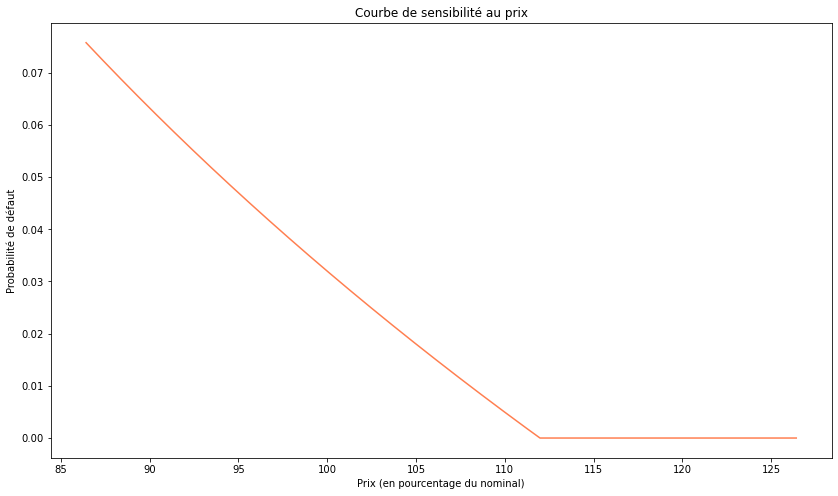

In [19]:
#PRIX
fig = plt.figure(1, figsize=(14, 8))

plt.plot(sensi_price["Mid Price"],sensi_price["PD_1y"],c='coral')
plt.title('Courbe de sensibilité au prix')
plt.xlabel('Prix (en pourcentage du nominal)')
plt.ylabel('Probabilité de défaut')

**Interprétation :** la probabilité de défaut est décroissante avec le prix. Cela est conforme à l'intuition. (si le bond n'était pas "sûr", ne serait pas acheté cher. A l'inverse, un bond peu cher paraît peu sûr). Existence d'un prix seuil au-delà duquel la PD est nulle.

Text(0, 0.5, 'Probabilité de défaut')

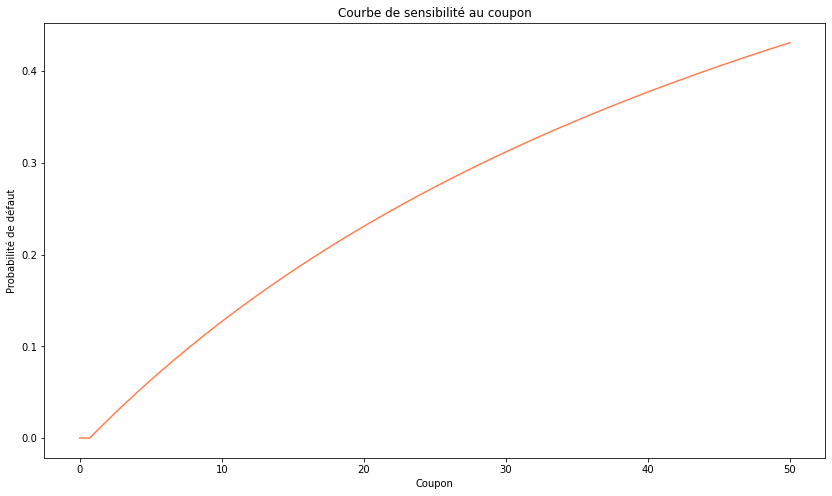

In [29]:
#COUPON
fig = plt.figure(1, figsize=(14, 8))

plt.plot(sensi_coupon["Cpn"],sensi_coupon["PD_1y"],c='coral')
plt.title('Courbe de sensibilité au coupon')
plt.xlabel('Coupon')
plt.ylabel('Probabilité de défaut')

**Interprétation :** la PD augmente avec le prix du coupon, ce qui est conforme à l'intuition. Plus le coupon est élevé, plus la probabilité (toutes choses égales par ailleurs) de ne pas le payer est grande.

In [21]:
#MATURITE

def time(row) : 
    mat = row["Maturity"]
    return (datetime.strptime(mat,'%m/%d/%Y') - datetime.strptime('07/29/2021','%m/%d/%Y')).days

sensi_maturity["delta_time"] = sensi_maturity.apply(time,axis=1)

Text(0, 0.5, 'Probabilité de défaut')

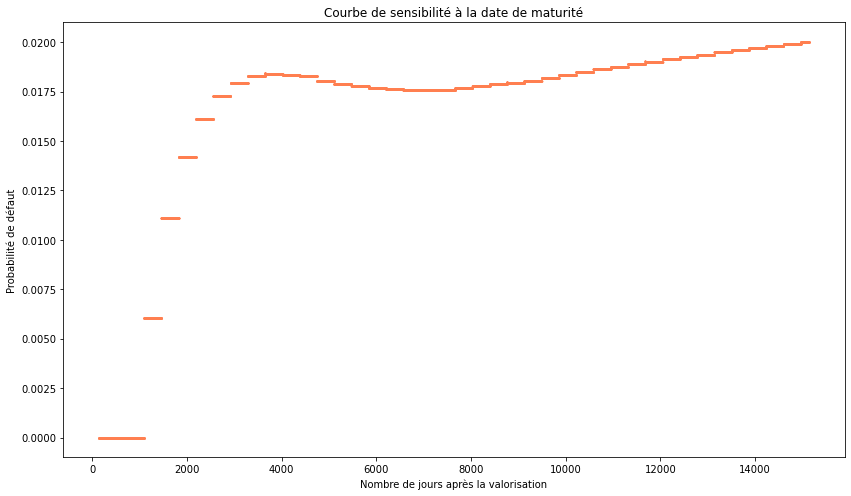

In [30]:
fig = plt.figure(1, figsize=(14, 8))

plt.scatter(sensi_maturity["delta_time"],sensi_maturity["PD_1y"],c='coral',s = 1)
plt.title('Courbe de sensibilité à la date de maturité')
plt.xlabel('Nombre de jours après la valorisation')
plt.ylabel('Probabilité de défaut')

En abscisses : nombre de jours entre la maturité du bond et le jour pris comme référence sur Bloom (29 juillet 2021). 

**Interprétation :** présence de paliers, dûs à la formule de valorisation du bonds (payement trimestriel des coupons). La probabilité de défaut n'est pas strictement croissante. 